In [94]:
import netket as nk
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import json
from scipy import sparse
from scipy.sparse import linalg
import config
import e2h
import nkutil

# System Size
L = 4
# Couplings J1 and J2
J = [1.0, 0.5]


# Sigma^z*Sigma^z interactions
sigmaz = [[1, 0], [0, -1]]
mszsz = np.kron(sigmaz, sigmaz)

# Exchange interactions
exchange = np.asarray([[0, 0, 0, 0], [0, 0, 2, 0], [0, 2, 0, 0], [0, 0, 0, 0]])

bond_operator = [
    (J[0] * mszsz).tolist(),
    (J[0] * mszsz).tolist(),
    (J[1] * mszsz).tolist(),
    (J[0] * exchange).tolist(),
    (J[0] * exchange).tolist(),
    (J[1] * exchange).tolist(),
]


bond_color = [1, 2, 3, 1, 2, 3]

json_data = open("json/graph_L" + str(L) + ".json").read()
data = json.loads(json_data)

# Define graph, hilbert space and hamiltonian
g = nk.graph.CustomGraph(data["EdgeColors"], data["Automorphisms"])
hi = nk.hilbert.Spin(s=0.5, total_sz=0.0, graph=g)
ha = nk.operator.GraphOperator(hi, bondops=bond_operator, bondops_colors=bond_color)

ham_mat = ha.to_sparse()
vals, vecs = sparse.linalg.eigsh(ham_mat, k=1, which="SA")
wfg = vecs[:, 0:1]

ndim = vecs.shape[0]

energies1 = []
overlaps1 = []
variance1 = []
j2_error1 = []
j3_error1 = []
a_error1 = []
aniso_error1 = []
run_data = {}



energies2 = []
overlaps2 = []
variance2 = []
j2_error2 = []
j3_error2 = []
a_error2 = []
aniso_error2 = []

target_overlaps = np.linspace(1, 0.995, 10)


In [95]:
noises = np.linspace(0.002, 0.000, 100)
overlaps = []
for i in range(len(noises)):
    noise1 = np.random.normal(scale=1, size=(ndim))
    wf1 = vecs[:, 0] + noises[i] * noise1
    wf1 /= np.linalg.norm(wf1)
    wf1 = wf1.reshape(-1, 1)
    overlaps.append(np.abs(np.vdot(wfg, wf1)))
    
from scipy import interpolate
overlaps = np.array(overlaps)
tck = interpolate.splrep(overlaps, noises, s=0)


for i in range(len(target_overlaps)):
    noise1 = np.random.normal(scale=1, size=(ndim))
    wf1 = vecs[:, 0] + interpolate.splev(target_overlaps[i], tck) * noise1
    wf1 /= np.linalg.norm(wf1)
    wf1 = wf1.reshape(-1, 1)
    energy = np.real((wf1.T.conj() @ ham_mat @ wf1)[0, 0])
    energies1.append(energy)
    overlaps1.append(np.abs(np.vdot(wfg, wf1)))
    variance1.append(
        np.real(((wf1.T.conj() @ ham_mat) @ (ham_mat @ wf1))[0, 0]) - energy * energy
    )
    
    
    cfg = config.default()
    cfg['geom_len_x'] = 4
    cfg['geom_len_y'] = 4
    cfg['ops_dist'] = 3
    cfg['ops_symmetries'] = 'trans_x,trans_y,rot,su2'
    cfg['exact_eigens'] = 1
    cfg['ham_j2'] = 0.5
    rotate_sites = []
    operators, lat, graph, hi, ham = e2h.prepare_hilbert(cfg)
    observables = nkutil.convert_observables(hi, operators, rotate_sites)
    e2h.measure_exact_wf(cfg, run_data, {'vecs': [wf1], 'vals': [0]}, observables)
    data = e2h.diagonalize(cfg, hi, ham, None, lat, rotate_sites, run_data, run_data['exact_meas'], operators, 8, 1e-7, False, False, True)
    j3_error1.append(data['eigens'][0]['h'][1])
    
    cfg = config.default()
    cfg['geom_len_x'] = 4
    cfg['geom_len_y'] = 4
    cfg['ops_dist'] = 2
    cfg['ops_symmetries'] = 'trans_x,trans_y,rot,su2'
    cfg['exact_eigens'] = 1
    cfg['ham_j2'] = 0.5
    rotate_sites = []
    operators, lat, graph, hi, ham = e2h.prepare_hilbert(cfg)
    observables = nkutil.convert_observables(hi, operators, rotate_sites)
    e2h.measure_exact_wf(cfg, run_data, {'vecs': [wf1], 'vals': [0]}, observables)
    data = e2h.diagonalize(cfg, hi, ham, None, lat, rotate_sites, run_data, run_data['exact_meas'], operators, 8, 1e-7, False, False, True)
    j2_error1.append(data['eigens'][0]['h'][1] / data['eigens'][0]['h'][0] - 0.5)

    cfg = config.default()
    cfg['geom_len_x'] = 4
    cfg['geom_len_y'] = 4
    cfg['ops_dist'] = 2
    cfg['ops_symmetries'] = 'trans_x,trans_y,rot'
    cfg['exact_eigens'] = 1
    cfg['ham_j2'] = 0.5
    cfg['ops_only_aniso'] = 2
    rotate_sites = []
    operators, lat, graph, hi, ham = e2h.prepare_hilbert(cfg)
    observables = nkutil.convert_observables(hi, operators, rotate_sites)
    e2h.measure_exact_wf(cfg, run_data, {'vecs': [wf1], 'vals': [0]}, observables)
    data = e2h.diagonalize(cfg, hi, ham, None, lat, rotate_sites, run_data, run_data['exact_meas'], operators, 8, 1e-7, False, False, True)
    a_error1.append(data['eigens'][0]['h'][1] / data['eigens'][0]['h'][0])

*** [J1J2, 2-site SU2 (2,0) (0,-2)]
*** measured energy: 0
*** diagonalizing covariance...
*** that took 0.0 s
*** -- ΔH0: -4.547473508864644e-13
*** ---- H0:
*** -- ΔH1: 185.98724944191673
*** ---- H1:
*** 1.2225229209287254e-15 * J1J2 (D = 0.9999999999999988)
*** 1.0 * 2-site SU2 (2,0) (0,-2) (D = -1.0)
*** variance of exact hamiltonian with Q: -4.547473508864641e-13
*** variance of best hamiltonian with Q: -4.547473508864644e-13
*** rejection of h0 onto subspace of best eigenvectors has norm 1.2225229209287254e-15
*** projection of h0 onto subspace of best eigenvectors has norm 1.0
*** J1J2 -33.8316934055794
*** 2-site SU2 (2,0) (0,-2) 15.120890876856011
*** [2-site SU2 (0,1) (1,0), 2-site SU2 (-1,1) (1,1)]
*** measured energy: 0
*** diagonalizing covariance...
*** that took 0.0 s
*** -- ΔH0: -2.7711166694643907e-13
*** ---- H0:
*** -- ΔH1: 364.72381707217687
*** ---- H1:
*** 0.4472135954999585 * 2-site SU2 (0,1) (1,0) (D = 0.4472135954999574)
*** -0.8944271909999155 * 2-site SU2 (-

*** measured energy: 0
*** diagonalizing covariance...
*** that took 0.0 s
*** -- ΔH0: 3.967179389907954
*** ---- H0:
*** 0.9873197630941047 * J1J2 (D = 0.012680236905895259)
*** -0.15874408777589435 * Anisotropy (D = 0.15874408777589435)
*** -- ΔH1: 12.836765903244313
*** ---- H1:
*** 0.15874408777589435 * J1J2 (D = 0.8412559122241057)
*** 0.9873197630941047 * Anisotropy (D = -0.9873197630941047)
*** variance of exact hamiltonian with Q: 4.190690179705825
*** variance of best hamiltonian with Q: 3.967179389907954
*** rejection of h0 onto subspace of best eigenvectors has norm 0.15874408777589438
*** projection of h0 onto subspace of best eigenvectors has norm 0.9873197630941046
*** J1J2 -33.71935613335762
*** Anisotropy -11.240558156495604
*** [J1J2, 2-site SU2 (2,0) (0,-2)]
*** measured energy: 0
*** diagonalizing covariance...
*** that took 0.0 s
*** -- ΔH0: 5.532313515905546
*** ---- H0:
*** 0.9999191945451167 * J1J2 (D = 8.080545488331481e-05)
*** 0.012712371149589813 * 2-site SU2

*** measured energy: 0
*** diagonalizing covariance...
*** that took 0.0 s
*** -- ΔH0: 9.70079301743096
*** ---- H0:
*** 0.9997621879347143 * J1J2 (D = 0.00023781206528572518)
*** 0.021807511916604214 * 2-site SU2 (2,0) (0,-2) (D = -0.021807511916604214)
*** -- ΔH1: 187.90660088782474
*** ---- H1:
*** 0.021807511916604214 * J1J2 (D = 0.9781924880833958)
*** -0.9997621879347143 * 2-site SU2 (2,0) (0,-2) (D = 0.9997621879347143)
*** variance of exact hamiltonian with Q: 9.785541921507729
*** variance of best hamiltonian with Q: 9.70079301743096
*** rejection of h0 onto subspace of best eigenvectors has norm 0.021807511916604218
*** projection of h0 onto subspace of best eigenvectors has norm 0.9997621879347142
*** J1J2 -33.56883727550644
*** 2-site SU2 (2,0) (0,-2) 15.022854566624133
*** [2-site SU2 (0,1) (1,0), 2-site SU2 (-1,1) (1,1)]
*** measured energy: 0
*** diagonalizing covariance...
*** that took 0.0 s
*** -- ΔH0: 7.725736668975884
*** ---- H0:
*** 0.8867569632560085 * 2-site SU2

In [98]:
noises = np.linspace(0.002, 0.000, 100)
overlaps = []
for i in range(len(noises)):
    noise1 = np.random.exponential(scale=1, size=(ndim))
    wf1 = vecs[:, 0] + noises[i] * noise1
    wf1 /= np.linalg.norm(wf1)
    wf1 = wf1.reshape(-1, 1)
    overlaps.append(np.abs(np.vdot(wfg, wf1)))
    
from scipy import interpolate
overlaps = np.array(overlaps)
tck = interpolate.splrep(overlaps, noises, s=0)

for i in range(len(target_overlaps)):
    noise1 = np.random.exponential(scale=1, size=(ndim))
    wf1 = vecs[:, 0] + interpolate.splev(target_overlaps[i], tck) * noise1
    wf1 /= np.linalg.norm(wf1)
    wf1 = wf1.reshape(-1, 1)
    energy = np.real((wf1.T.conj() @ ham_mat @ wf1)[0, 0])
    energies2.append(energy)
    overlaps2.append(np.abs(np.vdot(wfg, wf1)))
    variance2.append(
        np.real(((wf1.T.conj() @ ham_mat) @ (ham_mat @ wf1))[0, 0]) - energy * energy
    )
    
    cfg = config.default()
    cfg['geom_len_x'] = 4
    cfg['geom_len_y'] = 4
    cfg['ops_dist'] = 3
    cfg['ops_symmetries'] = 'trans_x,trans_y,rot,su2'
    cfg['exact_eigens'] = 1
    cfg['ham_j2'] = 0.5
    rotate_sites = []
    operators, lat, graph, hi, ham = e2h.prepare_hilbert(cfg)
    observables = nkutil.convert_observables(hi, operators, rotate_sites)
    e2h.measure_exact_wf(cfg, run_data, {'vecs': [wf1], 'vals': [0]}, observables)
    data = e2h.diagonalize(cfg, hi, ham, None, lat, rotate_sites, run_data, run_data['exact_meas'], operators, 8, 1e-7, False, False, True)
    j3_error2.append(data['eigens'][0]['h'][1])
    
    cfg = config.default()
    cfg['geom_len_x'] = 4
    cfg['geom_len_y'] = 4
    cfg['ops_dist'] = 2
    cfg['ops_symmetries'] = 'trans_x,trans_y,rot,su2'
    cfg['exact_eigens'] = 1
    cfg['ham_j2'] = 0.5
    rotate_sites = []
    operators, lat, graph, hi, ham = e2h.prepare_hilbert(cfg)
    observables = nkutil.convert_observables(hi, operators, rotate_sites)
    e2h.measure_exact_wf(cfg, run_data, {'vecs': [wf1], 'vals': [0]}, observables)
    data = e2h.diagonalize(cfg, hi, ham, None, lat, rotate_sites, run_data, run_data['exact_meas'], operators, 8, 1e-7, False, False, True)
    j2_error2.append(data['eigens'][0]['h'][1] / data['eigens'][0]['h'][0] - 0.5)

    cfg = config.default()
    cfg['geom_len_x'] = 4
    cfg['geom_len_y'] = 4
    cfg['ops_dist'] = 2
    cfg['ops_symmetries'] = 'trans_x,trans_y,rot'
    cfg['exact_eigens'] = 1
    cfg['ham_j2'] = 0.5
    cfg['ops_only_aniso'] = 2
    rotate_sites = []
    operators, lat, graph, hi, ham = e2h.prepare_hilbert(cfg)
    observables = nkutil.convert_observables(hi, operators, rotate_sites)
    e2h.measure_exact_wf(cfg, run_data, {'vecs': [wf1], 'vals': [0]}, observables)
    data = e2h.diagonalize(cfg, hi, ham, None, lat, rotate_sites, run_data, run_data['exact_meas'], operators, 8, 1e-7, False, False, True)
    a_error2.append(data['eigens'][0]['h'][1] / data['eigens'][0]['h'][0])

*** [J1J2, 2-site SU2 (2,0) (0,-2)]
*** measured energy: 0
*** diagonalizing covariance...
*** that took 0.0 s
*** -- ΔH0: -2.779695298451623e-28
*** ---- H0:
*** -- ΔH1: 185.98724944191568
*** ---- H1:
*** 1.2225229209287353e-15 * J1J2 (D = 0.9999999999999988)
*** -1.0 * 2-site SU2 (2,0) (0,-2) (D = 1.0)
*** variance of exact hamiltonian with Q: 0.0
*** variance of best hamiltonian with Q: -2.779695298451623e-28
*** rejection of h0 onto subspace of best eigenvectors has norm 1.2225229209287353e-15
*** projection of h0 onto subspace of best eigenvectors has norm 1.0
*** J1J2 -33.83169340557939
*** 2-site SU2 (2,0) (0,-2) 15.120890876855999
*** [2-site SU2 (0,1) (1,0), 2-site SU2 (-1,1) (1,1)]
*** measured energy: 0
*** diagonalizing covariance...
*** that took 0.0 s
*** -- ΔH0: -8.029132914089132e-13
*** ---- H0:
*** -- ΔH1: 364.72381707217187
*** ---- H1:
*** 0.4472135954999572 * 2-site SU2 (0,1) (1,0) (D = 0.44721359549995865)
*** -0.8944271909999162 * 2-site SU2 (-1,1) (1,1) (D = 1.

*** measured energy: 0
*** diagonalizing covariance...
*** that took 0.0 s
*** -- ΔH0: 10.715555853875033
*** ---- H0:
*** 0.6413359896444083 * J1J2 (D = 0.3586640103555917)
*** -0.7672601569134339 * Anisotropy (D = 0.7672601569134339)
*** -- ΔH1: 15.33165293845111
*** ---- H1:
*** 0.7672601569134339 * J1J2 (D = 0.23273984308656614)
*** 0.6413359896444083 * Anisotropy (D = -0.6413359896444083)
*** variance of exact hamiltonian with Q: 13.432997499367957
*** variance of best hamiltonian with Q: 10.715555853875033
*** rejection of h0 onto subspace of best eigenvectors has norm 0.767260156913434
*** projection of h0 onto subspace of best eigenvectors has norm 0.6413359896444083
*** J1J2 -33.636063442208965
*** Anisotropy -11.238625267288876
*** [J1J2, 2-site SU2 (2,0) (0,-2)]
*** measured energy: 0
*** diagonalizing covariance...
*** that took 0.0 s
*** -- ΔH0: 17.309321520256596
*** ---- H0:
*** 0.999938209744039 * J1J2 (D = 6.179025596098064e-05)
*** -0.011116505470973604 * 2-site SU2 (

*** measured energy: 0
*** diagonalizing covariance...
*** that took 0.0 s
*** -- ΔH0: 30.898925793971255
*** ---- H0:
*** 0.9997638713771406 * J1J2 (D = 0.0002361286228593773)
*** -0.0217301976289276 * 2-site SU2 (2,0) (0,-2) (D = 0.0217301976289276)
*** -- ΔH1: 187.39680061831248
*** ---- H1:
*** 0.0217301976289276 * J1J2 (D = 0.9782698023710724)
*** 0.9997638713771406 * 2-site SU2 (2,0) (0,-2) (D = -0.9997638713771406)
*** variance of exact hamiltonian with Q: 30.97282432348743
*** variance of best hamiltonian with Q: 30.898925793971255
*** rejection of h0 onto subspace of best eigenvectors has norm 0.021730197628927597
*** projection of h0 onto subspace of best eigenvectors has norm 0.9997638713771406
*** J1J2 -33.37912234034168
*** 2-site SU2 (2,0) (0,-2) 15.126009905705725
*** [2-site SU2 (0,1) (1,0), 2-site SU2 (-1,1) (1,1)]
*** measured energy: 0
*** diagonalizing covariance...
*** that took 0.0 s
*** -- ΔH0: 24.65720836400409
*** ---- H0:
*** 0.8858432364394524 * 2-site SU2 (0

In [45]:
variance1

[6.468335289291872,
 6.927033692875057,
 7.118169844089152,
 7.333284308349903,
 7.60301895149928]

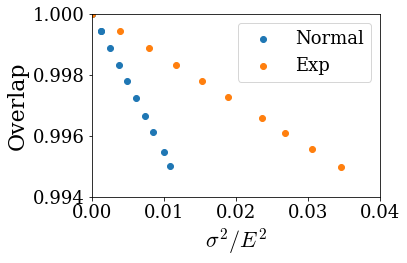

In [81]:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 18}
import matplotlib
matplotlib.rc('font', **font)
matplotlib.rc('mathtext', fontset='cm')

plt.scatter(variance1/vals[0]**2, overlaps1, label="Normal")
plt.scatter(variance2/vals[0]**2, overlaps2, label="Exp")
# plt.axhline(y=vals[0], xmin=0, xmax=1, label="GS Energy")
plt.ylabel("Overlap", fontsize=22)
plt.xlabel("$\\sigma^2/E^2$", fontsize=22)
plt.legend()

plt.ylim([0.994, 1])
plt.xlim([0, 0.04])
#plt.gca().set_xticks([0.988, 0.99, 0.992])
plt.tight_layout()
plt.savefig("/mnt/z/Users/Kevin/Pictures/ex1.png", dpi=300)

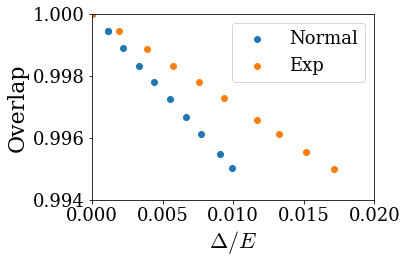

In [84]:
plt.scatter((vals[0] - np.array(energies1)) / vals[0], overlaps1, label="Normal")
plt.scatter((vals[0] - np.array(energies2)) / vals[0], overlaps2, label="Exp")
# plt.axhline(y=vals[0], xmin=0, xmax=1, label="GS Energy")
plt.ylabel("Overlap", fontsize=22)
plt.xlabel("$\\Delta/E$", fontsize=22)
plt.legend()
plt.ylim([0.994, 1])
plt.xlim([0, 0.02])
plt.tight_layout()
plt.savefig("/mnt/z/Users/Kevin/Pictures/ex1.5.png", dpi=300)

In [91]:
len(j3_error1)

11

In [93]:
overlaps1

[0.9999999999999997,
 0.999445127808481,
 0.9999999999999997,
 0.9994425231390752,
 0.9988881096296023,
 0.9983154363558688,
 0.997797902941961,
 0.997250667879836,
 0.9966589821502538,
 0.9961363970846144,
 0.9954690052143232,
 0.9950118973850237]

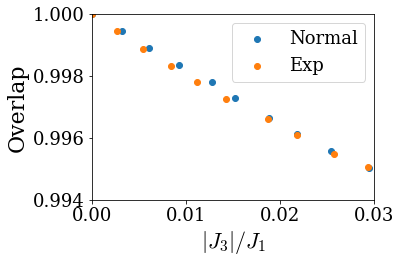

In [99]:
plt.scatter(j3_error1, overlaps1, label="Normal")
plt.scatter(-np.array(j3_error2), np.array(overlaps2), label="Exp")
plt.ylabel("Overlap", fontsize=22)
plt.xlabel("$|J_3|/J_1$", fontsize=22)
plt.legend()
# plt.gca().set_xticks([0.988, 0.99, 0.992])
plt.ylim([0.994, 1])
plt.xlim([0, 0.03])
plt.tight_layout()
plt.savefig("/mnt/z/Users/Kevin/Pictures/ex2.png", dpi=300)

ValueError: x and y must be the same size

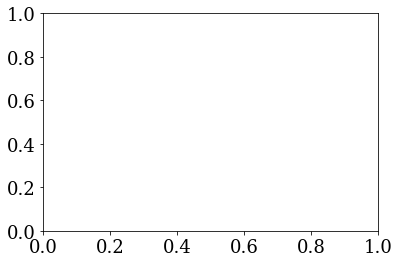

In [11]:
plt.scatter(overlaps1, np.array(j2_error1) - 0.4, label="Normal")
plt.scatter(overlaps2, np.array(j2_error2) - 0.4, label="Exp")
plt.xlabel("Overlap")
plt.ylabel("|J_2 - 0.5|")
plt.legend()
plt.gca().set_xticks([0.988, 0.99, 0.992])
plt.tight_layout()
plt.savefig("/mnt/z/Users/Kevin/Pictures/ex2.png", dpi=300)

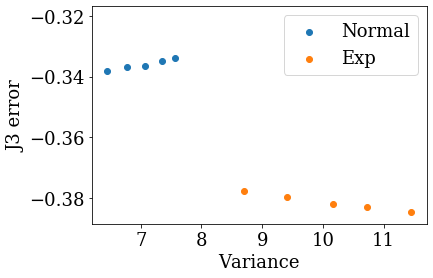

In [9]:
plt.scatter(variance1, j3_error1, label="Normal")
plt.scatter(variance2, j3_error2, label="Exp")
plt.xlabel("Variance")
plt.ylabel("J3 error")
plt.legend()